In [1]:
# This line will add a button to toggle visibility of code blocks,
# for use with the HTML export version
from IPython.core.display import HTML
HTML('''<button style="margin:0 auto; display: block;" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle();">Toggle code</button>''')

<img src="./Images/UoE_Horizontal_Logo_282_v1_160215.png" alt="drawing" width="600"/>

# Week 9 - Tree-Based Methods
__Dr. David Elliott__
    
7. [Imballanced Data](#imb)

8. [Feature Interpretation/Reduction](#feats)
    
9. [Strengths and Limitations](#adv_lim)

In [2]:
%matplotlib inline

import os # locating directories

import numpy as np   # Arrays
import pandas as pd  # DataFrames

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")
# Initial fig number
fig_num=0

plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

In [3]:
# Centered figures in the notebook and presentation
# ...was a real pain to find this:
# https://gist.githubusercontent.com/maxalbert/800b9f06c7b2dd365ea5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
import base64
from io import BytesIO, StringIO

def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

In [4]:
# TODO: when tidying this up in the future, but these common functions I use
# all the time in a separate .py file.
def hyper_search(model, params, X, y, save_path, n_iter=60, metric="accuracy", 
                 cv = KFold(5), random_state=42, refit=True,
                 overwrite=False, warning=False, verbose=0):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params, scoring=metric, cv=cv, 
                                  refit=refit, return_train_score=True, verbose=verbose)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            if verbose>0:
                print("Starting "+search_type)
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, scoring=metric, cv=cv,
                                        refit=refit, random_state=random_state,
                                        return_train_score=True, verbose=verbose)
        
        start = time()
        if warning:
            models.fit(X, y)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                models.fit(X, y)
        
        if verbose>0:
            print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

## Dataset Example: Lending Club<sup>18</sup>

LendingClub (was) the world's largest peer-to-peer lending platform. 

Investors were able to search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. 
- Investors make money from the interest on these loans. 
- LendingClub makes money by charging borrowers an origination fee and investors a service fee.

In [5]:
df = pd.read_csv('../Data/LCData/LC_reduced.csv')
df = df.drop("Unnamed: 0", axis=1)
df.head()

,loan_amnt,int_rate,annual_inc,dti,total_acc,term,home_ownership,emp_length,open_acc,pub_rec,...,mort_acc,avg_cur_bal,delinq_amnt,fico_range_high,fico_range_low,num_bc_tl,num_tl_90g_dpd_24m,zip_code,installment,loan_status
0,17000.0,8.99%,105000.0,14.82,13.0,36 months,RENT,3 years,7.0,0.0,...,0.0,5321.0,0.0,734.0,730.0,3.0,0.0,941xx,540.52,Fully Paid
1,7500.0,15.61%,75000.0,24.14,19.0,36 months,RENT,6 years,14.0,0.0,...,3.0,17895.0,0.0,699.0,695.0,9.0,0.0,027xx,262.24,Fully Paid
2,12000.0,10.49%,44000.0,17.76,24.0,60 months,RENT,2 years,13.0,0.0,...,0.0,1280.0,0.0,794.0,790.0,6.0,0.0,231xx,257.87,Fully Paid
3,10000.0,11.05%,72000.0,8.45,20.0,36 months,MORTGAGE,5 years,6.0,0.0,...,2.0,9165.0,0.0,669.0,665.0,7.0,0.0,499xx,327.63,Fully Paid
4,24000.0,5.32%,235000.0,9.23,21.0,36 months,MORTGAGE,< 1 year,12.0,0.0,...,2.0,20279.0,0.0,754.0,750.0,5.0,0.0,332xx,722.76,Fully Paid


__Notes__

- It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market.
- headquartered in San Francisco, California
- It now takes an institutional investor-focused approach
- Its loan trading platform was closed down in 2020

When a person applies for a loan, there are two types of decisions that could be taken by the company<sup>18</sup>:

- __Loan accepted__: If the company approves the loan, there are 3 possible scenarios described below:
    - _Fully paid_: Applicant has fully paid the loan (the principal and the interest rate)
    - _Current_: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed.
    - _Charged-off_: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan
- __Loan rejected__: The company had rejected the loan (because the candidate does not meet their requirements etc.).

- _"It now presents the algorithm just as a search tool for investors to find Notes they would like to purchase, using borrower and loan attributes such as the length of a loan term, target weighted average interest rate, borrower credit score, employment tenure, homeownership status, and others.[63]"_ 
- _"To reduce default risk, LendingClub focuses on high-credit-worthy borrowers, declining approximately 90% of the loan applications it received as of 2012[64] and assigning higher interest rates to riskier borrowers within its credit criteria.[23]"_ 
- _"Only borrowers with FICO score of 660 or higher can be approved for loans.[54]"_
- Lending Club blends traditional credit reports with data gathered from around the web.

In [6]:
df['fico_range_low'].min()

660.0

When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

- If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
- If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

The data given contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16775 entries, 0 to 16774
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             16775 non-null  float64
 1   int_rate              16775 non-null  object 
 2   annual_inc            16775 non-null  float64
 3   dti                   16775 non-null  float64
 4   total_acc             16775 non-null  float64
 5   term                  16775 non-null  object 
 6   home_ownership        16775 non-null  object 
 7   emp_length            16775 non-null  object 
 8   open_acc              16775 non-null  float64
 9   pub_rec               16775 non-null  float64
 10  pub_rec_bankruptcies  16775 non-null  float64
 11  mort_acc              16775 non-null  float64
 12  avg_cur_bal           16775 non-null  float64
 13  delinq_amnt           16775 non-null  float64
 14  fico_range_high       16775 non-null  float64
 15  fico_range_low     

In [8]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
info = pd.read_excel("../Data/LCData/LCDataDictionary.xlsx")
info = info[['LoanStatNew','Description']].iloc[0:-2]
display(info.set_index('LoanStatNew').loc[df.columns].sort_index())
pd.reset_option('all')

,Description
annual_inc,The self-reported annual income provided by the borrower during registration.
avg_cur_bal,Average current balance of all accounts
delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.
dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
installment,The monthly payment owed by the borrower if the loan originates.
int_rate,Interest Rate on the loan


As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\delliot2\.conda\envs\mlp_pip\lib\site-packages\pandas\_config\config.py:620: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\delliot2\.conda\envs\mlp_pip\lib\site-packages\pandas\_config\config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [9]:
print(color.BOLD+color.UNDERLINE+"Loan Status (%)"+color.END)
((df['loan_status'].value_counts()/len(df['loan_status']))*100).round(2)

Loan Status (%)


Fully Paid     80.81
Charged Off    19.19
Name: loan_status, dtype: float64

### Data Prep

For the purposes of this lecture, we are only using a sample of the full dataset (~1%). This is to ensure things dont take an age to run. 

- You can have a look at how I prepared the data and reduced it down in the "Loan_Club_Explore_and_Prep.ipynb" found in the "Extra" folder.
- You could also try play with the larger sample of data.
- There are also 150 columns so loads of features, some of them potentially concerning!

In [10]:
# turn intrest rate into a float
df['int_rate'] = df['int_rate'].str.replace(r'%', '').astype(float)
# get the employment length in years
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(int)
# get the loan term in months
df['term'] = df['term'].str.extract('(\d+)').astype(int)
# we are going to remove categorical variables for now as scikit-learn
# doesnt like them (see later).
cont_df = df.drop(['home_ownership', 'zip_code'], axis=1)
cont_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16775 entries, 0 to 16774
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             16775 non-null  float64
 1   int_rate              16775 non-null  float64
 2   annual_inc            16775 non-null  float64
 3   dti                   16775 non-null  float64
 4   total_acc             16775 non-null  float64
 5   term                  16775 non-null  int32  
 6   emp_length            16775 non-null  int32  
 7   open_acc              16775 non-null  float64
 8   pub_rec               16775 non-null  float64
 9   pub_rec_bankruptcies  16775 non-null  float64
 10  mort_acc              16775 non-null  float64
 11  avg_cur_bal           16775 non-null  float64
 12  delinq_amnt           16775 non-null  float64
 13  fico_range_high       16775 non-null  float64
 14  fico_range_low        16775 non-null  float64
 15  num_bc_tl          

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

LE = LabelEncoder()
data_x, data_y = cont_df.drop(['loan_status'], axis=1), cont_df['loan_status']

# it will do this alpabetically but we want our positive value to
# be "charged off".
classes = list(cont_df['loan_status'].unique())
classes.sort(reverse=True)
LE.fit(classes)
LE.classes = np.array(classes)
LE.classes_ = np.array(classes)

data_y = LE.transform(data_y)

X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y, test_size = 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

# 7. Imballanced Data <a id='imb'></a>

## Forest
We can deal with class imballance using <code>class_weight = 'balanced'</code>, alike to discussed last week.

We can also undersample using a _ballanced random forest_, which builds several estimators on different randomly selected subsets of data. 

Generally what performs better depends on the amount of data you are training on and the aims of the model.

__Notes__
- Balanced Random Forests are generally faster to train.
- If data is small then class weight will probably be better (as seen below), but if you have very large datasets, then undersampling will likely work better.

In [12]:
# from https://realpython.com/python-timer/

import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.2f} seconds")
        return elapsed_time

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

t = Timer()

RF = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            random_state=42,
                            oob_score = True,
                            n_jobs=-1)

RF_weight = clone(RF)
RF_weight.set_params(**{'class_weight': 'balanced'})

bal_f = BalancedRandomForestClassifier(criterion='gini',
                                       n_estimators=100,
                                       max_features = 'sqrt',
                                       random_state=42,
                                       oob_score = True,
                                       n_jobs=-1)

rf_dict = {'Random Forest':RF, 'Random Forest (Balanced Class Weight)':RF_weight, 'Balanced Random Forest':bal_f}

for classifier_name in rf_dict:
    t.start()
    rf_dict[classifier_name].fit(X_train, y=y_train)
    print(color.BOLD+color.UNDERLINE+classifier_name+color.END)
    t.stop()
    print('OOB Score: %.3f' % (rf_dict[classifier_name].oob_score_))

Random Forest
Elapsed time: 0.69 seconds
OOB Score: 0.803
Random Forest (Balanced Class Weight)
Elapsed time: 0.65 seconds
OOB Score: 0.803
Balanced Random Forest
Elapsed time: 0.63 seconds
OOB Score: 0.635


__Notes__

- Remember from last week, accuracy can only tell us so much! 

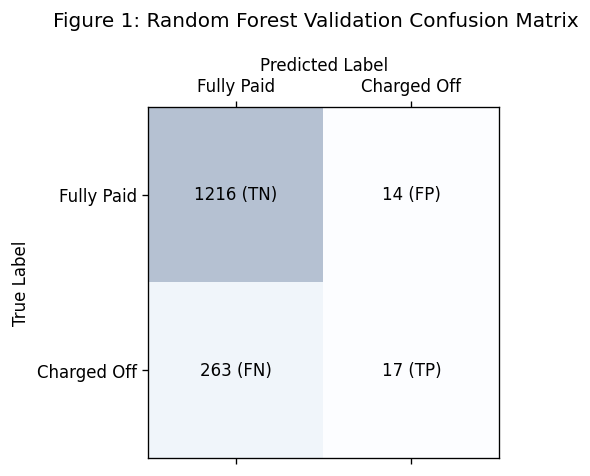

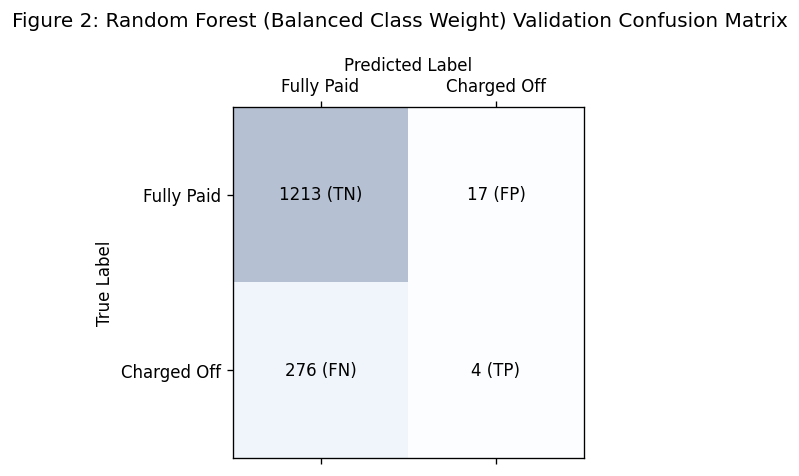

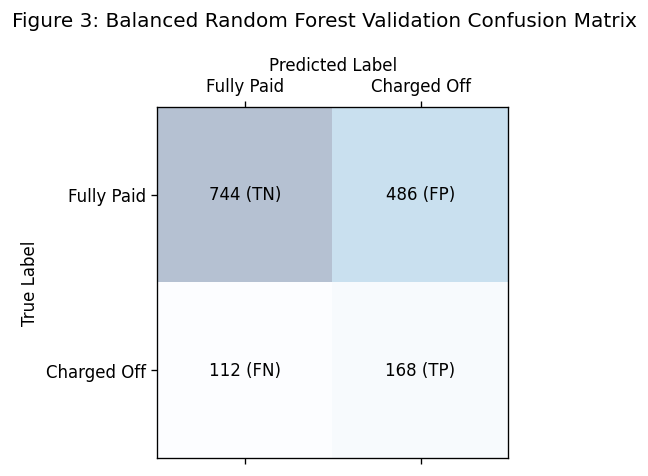

In [14]:
from sklearn.metrics import confusion_matrix
import warnings # prevent warnings

# this creates the matplotlib graph to make the confmat look nicer
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(width_inch, height_inch))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()
    

for classifier_name in rf_dict:
    # use the first classifier to predict the validation set    
    predictions = rf_dict[classifier_name].predict(X_val)

    # get the confusion matrix as a numpy array
    confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

    fig_num+=1
    # use the pretty function to make it nicer
    pretty_confusion_matrix(confmat, LE.classes_,
                            "Figure %d: "%fig_num+classifier_name+" Validation Confusion Matrix",
                            labeling=True,
                           )

__Notes__

- This looks like the problem we had last week, depending on what we try we either have poor performance on the minority class ("Charged Off") or have a high false positive rate.

In [15]:
from sklearn.metrics import classification_report

for i, classifier_name in enumerate(rf_dict):
    # use the first classifier to predict the validation set    
    predictions = rf_dict[classifier_name].predict(X_val)

    report = pd.DataFrame(classification_report(y_val, 
                                       predictions, 
                                       labels=None, 
                                       target_names=LE.classes_, 
                                       sample_weight=None, 
                                       digits=2, 
                                       output_dict=True)).round(2)
    report['classifer'] = classifier_name
    
    if i == 0:
        reports = report
    else:
        reports = pd.concat([reports, report])

reports.index.name = 'metric'
reports = reports.set_index('classifer', append=True)
reports = reports.swaplevel()
display(reports)

Fully Paid  Charged Off  \
classifer                             metric                               
Random Forest                         precision        0.82         0.55   
                                      recall           0.99         0.06   
                                      f1-score         0.90         0.11   
                                      support       1230.00       280.00   
Random Forest (Balanced Class Weight) precision        0.81         0.19   
                                      recall           0.99         0.01   
                                      f1-score         0.89         0.03   
                                      support       1230.00       280.00   
Balanced Random Forest                precision        0.87         0.26   
                                      recall           0.60         0.60   
                                      f1-score         0.71         0.36   
                                      support       1230.00       280.00   

                                                 accuracy  macro avg  \
classifer                             metric                           
Random Forest                         precision      0.82       0.69   
                                      recall         0.82       0.52   
                                      f1-score       0.82       0.50   
                                      support        0.82    1510.00   
Random Forest (Balanced Class Weight) precision      0.81       0.50   
                                      recall         0.81       0.50   
                                      f1-score       0.81       0.46   
                                      support        0.81    1510.00   
Balanced Random Forest                precision      0.60       0.56   
                                      recall         0.60       0.60   
                                      f1-score       0.60       0.54   
                                      support        0.60    1510.00   

                                                 weighted avg  
classifer                             metric                   
Random Forest                         precision          0.77  
                                      recall             0.82  
                                      f1-score           0.75  
                                      support         1510.00  
Random Forest (Balanced Class Weight) precision          0.70  
                                      recall             0.81  
                                      f1-score           0.73  
                                      support         1510.00  
Balanced Random Forest                precision          0.76  
                                      recall             0.60  
                                      f1-score           0.65  
                                      support         1510.00

The above was just done on pretty much the default params, so you'd want to do some searches to get better hyperparameters.

In [16]:
from time import time
import joblib
rf_param_dist = {'n_estimators': range(50, 500),
                 'max_features': range(1, X_train.shape[1]),
                 'class_weight': [None, 'balanced']}

lc_rf_rs = hyper_search(RF, rf_param_dist, X_train, y_train,
                        os.path.join(os.getcwd(), "Models", "lc_rf_rs.pkl"),
                        n_iter=60, overwrite=False, metric="f1", verbose=2)
display(pd.DataFrame(lc_rf_rs.cv_results_).sort_values("rank_test_score")[["param_n_estimators",
                                                                           "param_max_features",
                                                                           "param_class_weight",
                                                                           "mean_test_score", 
                                                                           "std_test_score"]].head())

,param_n_estimators,param_max_features,param_class_weight,mean_test_score,std_test_score
28,105,11,None,0.103820,0.016114
25,151,12,None,0.100164,0.012414
39,97,7,None,0.097164,0.012689
4,291,12,None,0.096904,0.013131
0,120,17,None,0.095412,0.007575


In [17]:
del rf_param_dist['class_weight']

lc_bal_rf_rs = hyper_search(bal_f, rf_param_dist, X_train, y_train,
                        os.path.join(os.getcwd(), "Models", "lc_bal_rf_rs.pkl"),
                        n_iter=60, overwrite=False, metric="f1", verbose=2)
display(pd.DataFrame(lc_bal_rf_rs.cv_results_).sort_values("rank_test_score")[["param_n_estimators",
                                                                               "param_max_features",
                                                                               "mean_test_score", 
                                                                               "std_test_score"]].head())

,param_n_estimators,param_max_features,mean_test_score,std_test_score
30,334,3,0.407487,0.015900
43,125,3,0.406370,0.017198
51,417,3,0.405944,0.017373
19,385,4,0.405593,0.013208
55,456,8,0.404155,0.017343


# 8. Feature Interpretation/Reduction <a id='feats'>
    
## Feature importances
    
Feature importances, as we have previously seen, can give us insight into the important features for our model.

In [18]:
fig = plt.figure(figsize = (width_inch, height_inch))

# get the importances for the features
rf_importances = lc_bal_rf_rs.best_estimator_.feature_importances_

rf_importances_series = pd.Series(rf_importances,index=data_x.columns).sort_index(ascending = False)

# plot the important features
rf_importances_series.plot.barh(legend =False, grid=False,)

fig_num+=1
plt.suptitle('Figure %d: Average Feature Importances for a Balanced Random Forest'%fig_num)
plt.tight_layout()
plt.close()
display(MatplotlibFigure(fig, centered=True))

We could also use the importance of each feature (using average impurity decrease), for feature selection.

We can put it in a pipeline and use the <code>SelectFromModel</code> function from Scikit-learn.

__Notes__

- We can provide both a numeric theshold or use a heuristic such as the mean and median<sup>5</sup>.

In [19]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

svm = SVC(kernel='rbf', random_state=42, class_weight = 'balanced')

rf_svm = Pipeline([
  ('feature_selection', SelectFromModel(lc_bal_rf_rs.best_estimator_, threshold = 'mean')),
  ('classification', svm)
])

svm_dict = {'SVM':svm, 'Forest SVM':rf_svm}

for classifier_name in svm_dict:
    scores = cross_val_score(estimator=svm_dict[classifier_name], 
                             X=X_train, 
                             y=y_train, 
                             scoring = 'f1',
                             cv=StratifiedKFold(),
                             n_jobs=-1)

    print(color.BOLD+color.UNDERLINE+classifier_name+color.END)
    print('CV f1-score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

SVM
CV f1-score: 0.343 +/- 0.007
Forest SVM
CV f1-score: 0.342 +/- 0.006


## Limitations

- Feature importances can be misleading for high cardinality features (many unique values)<sup>6</sup>

- If features are highly correlated, one feature may be ranked highly while the information of the others not being fully captured<sup>4</sup>. 

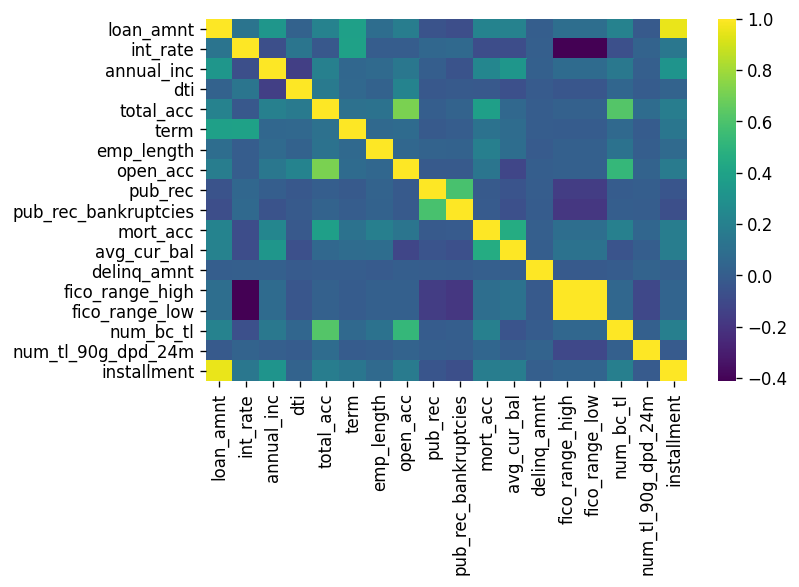

In [20]:
plt.figure(figsize=(width_inch, height_inch))
sns.heatmap(data_x.corr(), cmap='viridis')
plt.show()

## Permutation Importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled<sup>7</sup>.

This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature<sup>8</sup>.

__Notes__

- _" In the permutation-based approach, for each tree, the OOB sample is passed down the tree and the prediction accuracy is recorded. Then the values for each variable (one at a time) are randomly permuted and the accuracy is again computed. The decrease in accuracy as a result of this randomly shuffling of feature values is averaged over all the trees for each predictor. The variables with the largest average decrease in accuracy are considered most important."_<sup>9</sup>

- _"This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature."_ https://scikit-learn.org/stable/modules/permutation_importance.html

- _"Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit."_ https://scikit-learn.org/stable/modules/permutation_importance.html

- _"Warning: Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model."_ https://scikit-learn.org/stable/modules/permutation_importance.html

- For more examples of methods of interpreting forests see: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

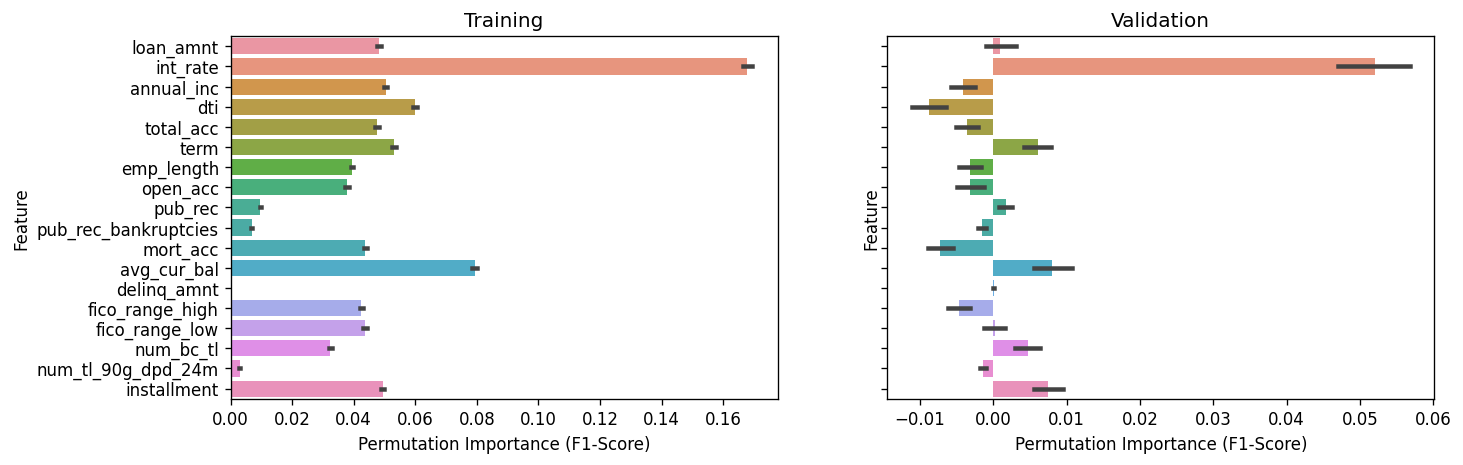

In [21]:
from sklearn.inspection import permutation_importance

fig, axes = plt.subplots(ncols = 2, figsize=(width_inch*2, height_inch), sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        X, y = X_train, y_train
        name = "Training"
    else:
        X, y = X_val, y_val
        name = "Validation"
    
    imp = permutation_importance(lc_bal_rf_rs.best_estimator_, X, y,
                                 n_repeats=30, scoring='f1', random_state=0)
    imp_df = pd.DataFrame(imp['importances']).T
    imp_df.columns = data_x.columns
    imp_df_ = imp_df.melt(var_name = 'Feature', value_name='Permutation Importance (F1-Score)')
    
    sns.barplot(data = imp_df_, x = 'Permutation Importance (F1-Score)', y = 'Feature', ax = ax)
    ax.set_title(name)
plt.show()

__Extra: Fairness__

In last weeks "Applications" notes I questioned what information is fair for us to use when making decisions around lending. Well this week we have a dataset which has some of these very varibles in which could be problematic. 
    
- zip_code
    - Maybe you think people who live in wealthy areas are more likely to pay back the loan? 
    - Doesn't this make it worse for people financially responcible people who live in poor areas? 
    - Might this unfortunately be related to someones race/ethnicity?
- pub_rec (Number of derogatory public records)
    - What do they define as a "derogatory public record"?
    - Should we use such a vauge feature that could include discrimatory information?
    - Does this include criminal history? Is the american criminal system unbias? Is this likely to account for certain types of crime over white colar crime?
- homeownership    
    - Among racial demographics in America, white people have the country's highest homeownership rate, while African Americans have the lowest. 
    - One study shows that homeownership rates appear correlated with higher school attainment. ("A Note on the Benefits of Homeownership, Federal Reserve Bank of Chicago" (PDF). Chicagofed.org. Retrieved October 14, 2017.)
       
If you look at the full list of varibles for this dataset (we've used a subset), you'll see there are even more features of which you may question their validity or fairness. Should we be including these varibles in our models, in other words should we be assigning weights to them? Without other demographic information (race, gender, ect.) can we ever try correct for them in our model?

More on this in week 11...

__Note__
- Lending Club use what Cathy O'Neil terms e-scores. You can read more about the issues with e-scores in chapter 8 of Weapons of Math Destruction.

# 9. Strengths and Limitations <a id='adv_lim'></a>

There are always advantages and disadvantages to using any model on a particular dataset. 

## Trees
### Advantages<sup>1,3,10</sup>
- Easy to explain
    - Trees can be displayed graphically in an interpretable mannor.
- Make few assumptions about the training data (non-parametric)
    - e.g. we don't assume the data is linear.
- Inherently multiclass
    - Can also handle multitask output (multiclass-multioutput)
- Can handle different types of predictors*
    - Independent of feature scaling
- Can handle missing values*
- Can handle multitask output (multiclass-multioutput)


\* limited or unavailable in Scikit-Learn

__Notes__
- _"Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic."_<sup>12</sup>
- Decision trees potentially more mirror human decision-making than the regression and classification approaches previously discussed.
- Generally, you'll find tree impliminations that are specialised for particular types of data.
- _"Warning At present, no metric in sklearn.metrics supports the multiclass-multioutput classification task."_<sup>11</sup>

### Extra: Categorical Features and Sklearn

You may also be wondering: where are my previous data visualisations of the categorical data before this? Well Sklearn's CART decision trees currently _"does not support categorical variables"_. This means:

- Do not use `Label Encoding` if your categorical data is __not ordinal__ with `DecisionTreeClassifier()`, you'll end up with splits that do not make sense, as the data will be treat as numeric<sup>13</sup>.

- Using a `OneHotEncoder` is the only current valid way with sklearn, allowing arbitrary splits not dependent on the label ordering, but is computationally expensive and it can deteriorate the performance of decision trees as it leads to sparse features, which can mess up feature importance<sup>12</sup>.

__Solutions__

Currently the best way of handling categorical features is to use <code>h2o.randomForest</code>, a different forest implimentation, or <code>catboost</code>, a boosting classifier. 

__Notes__
- H2o has sklearn support which may be useful to look into: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/h2o-client.html

### Disadvantages<sup>1,10</sup>

- Comparatively poor generalization performance.

- Easy to overfit
    - Require pruning

- High variance
    - A small change in the data can cause a large change in the estimated tree.

- Orthogonal decision boundaries
    - Model affected by the rotation of the data.
    
- Cannot guarantee to return the globally optimal decision tree.
    - locally optimal decisions are made at each node.

__Notes__
- If there is a highly non-linear and complex relationship between the features and the response then decision trees may outperform classical approaches. However if the relationship between the features and the response is well approximated by a linear model, then an approach such as linear regression will likely work well<sup>1</sup>.
- A decision tree is quite boxy. How the model makes a decision boundary is going to be affected by the rotation of the data (as DTs create straight lines).

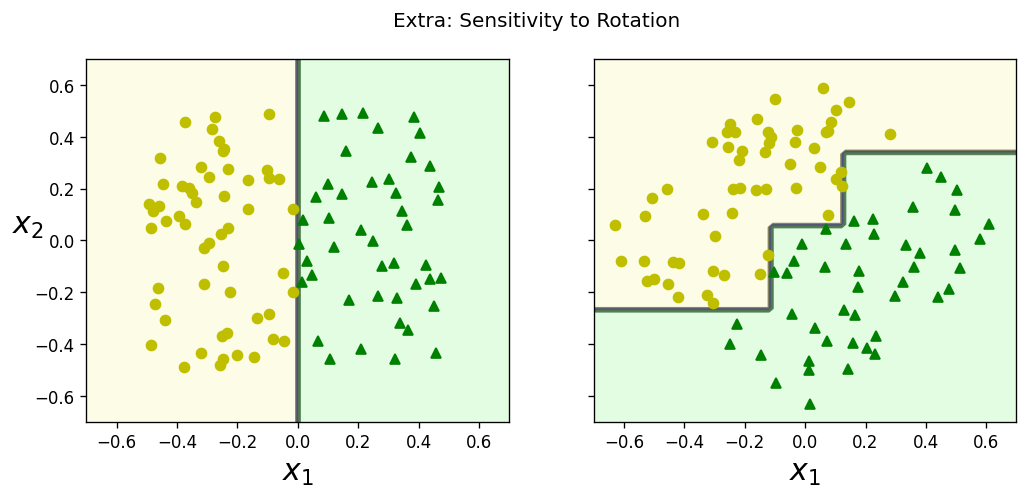

In [24]:
# from https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")
plt.suptitle("Extra: Sensitivity to Rotation")

plt.show()

## Forests/ExtraTrees

Generally improve upon trees, at the expense of interpretability.

### Advantages

- Comparatively good generalisability
    - Not too affected by outlier observations.
    - Can still overfit<sup>16</sup> but much less likely

- Comparatively small variability in prediction accuracy when tuning<sup>14</sup>

- Comparatively good “out of the box” performance<sup>15</sup>
    - Easy of use
    - not much tuning required to get good results

- ExtraTrees is faster to train than random forests
    - Its time consuming to to find the best theshold for each feature at each node<sup>3</sup>.

- Work well on large datasets

### Disadvantages

- Not good for very high-dimensional sparse data<sup>17</sup>.
    - e.g. text

- Harder than trees to interpret
    - Trees in random forests tend to be deeper than decision trees (due to feature subsets)<sup>17</sup>.
    
- More computationally demanding to train than other algorithms<sup>17</sup>
    - Require more memory and are slower to train and to predict than linear models.
    - However, they can be easily parallelized across multiple CPU cores.

- Setting different random states can drastically change the model<sup>17</sup>.
    - The more trees, the more robust to this they are to this.

__Notes__
- Using more CPU cores will result in linear speed-ups<sup>17</sup>.
- _'As concluding remarks about ensemble techniques, it is worth noting that ensemble learning increases the computational complexity compared to individual classifiers. In practice, we need to think carefully about whether we want to pay the price of increased computational costs for an often relatively modest improvement in predictive performance. An often-cited example of this tradeoff is the famous \$1 million Netflix Prize, which was won using ensemble techniques. The details about the algorithm were published in The BigChaos Solution to the Netflix Grand Prize by A. Toescher, M. Jahrer, and R. M. Bell, Netflix Prize documentation, 2009, which is available at http://www.stat.osu.edu/~dmsl/GrandPrize2009_BPC_BigChaos.pdf. The winning team received the $1 million grand prize money; however, Netflix never implemented their model due to its complexity, which made it infeasible for a real-world application: "We evaluated some of the new methods offline but the additional accuracy gains that we measured did not seem to justify the engineering effort needed to bring them into a production environment." http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html'_<sup>4</sup>

# References
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
2. Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
5. http://scikit-learn.org/stable/modules/feature_selection.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
7. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001
8. https://scikit-learn.org/stable/modules/permutation_importance.html
9. https://bradleyboehmke.github.io/HOML/random-forest.html
10. https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf
11. https://scikit-learn.org/stable/modules/multiclass.html
12. https://scikit-learn.org/stable/modules/tree.html
13. https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree
14. Probst, Philipp, Bernd Bischl, and Anne-Laure Boulesteix. 2018. “Tunability: Importance of Hyperparameters of Machine Learning Algorithms.” arXiv Preprint arXiv:1802.09596.
15. https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf.
16. Segal MR: Machine Learning Benchmarks and Random Forest Regression. Technical Report, Center for Bioinformatics & Molecular Biostatistics, University of California, San Francisco 2004.
17. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. " O'Reilly Media, Inc.".
18. https://www.kaggle.com/faressayah/lending-club-loan-defaulters-prediction

In [ ]:
import sys
from shutil import copyfile

# where the HTML template is located
dst = os.path.join(sys.prefix, 'lib', 'site-packages', 'nbconvert', 'templates', "classic.tplx")

# If its not located where it should be
if not os.path.exists(dst):
    # uses a nb_pdf_template
    curr_path = os.path.join(os.getcwd(),"..", "Extra", "classic.tplx")
    # copy where it is meant to be
    copyfile(curr_path, dst)

# Create HTML notes document
!jupyter nbconvert 3_Applications.ipynb \
    --to html \
    --output-dir . \
    --template classic
!jupyter nbconvert 3_Applications.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

# Create pdf notes document (issues)
!jupyter nbconvert 3_Applications.ipynb \
    --to html \
    --output-dir ./PDF_Prep \
    --output 3_Applications_no_code \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True